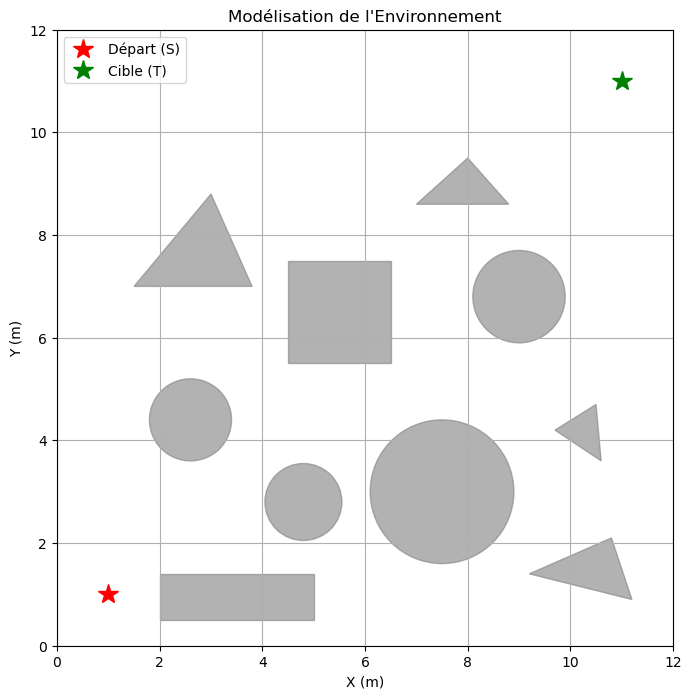

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Circle, Rectangle, Polygon 
class Environnement:
    """ 
    Modélise l'espace de travail 12m x 12m. Gère les obstacles et la détection stricte de collision.
    """
    def __init__(self, obstacles, start_point, target_point, limites=(0, 12, 0, 12)):
        self.obstacles = obstacles
        self.start_point = np.array(start_point)
        self.target_point = np.array(target_point)
        self.limites = limites

    def _sign(self, p1, p2, p3): 
        """calcule le produit vectoriel 2D,Utilisée pour déterminer de quel côté d'une ligne se trouve un point."""
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    def _point_in_triangle(self, pt, v1, v2, v3):
        """ 
        Algorithme de vérification Barycentrique : vérifie si le point 'pt' est 
        à l'intérieur du triangle formé par les sommets v1, v2 et v3.
        """
        d1 = self._sign(pt, v1, v2)
        d2 = self._sign(pt, v2, v3)
        d3 = self._sign(pt, v3, v1)
  # Un point est dans le triangle s'il est du même côté de toutes les arêtes
        return not ((d1 < 0 or d2 < 0 or d3 < 0) and (d1 > 0 or d2 > 0 or d3 > 0)) 

    def est_en_collision(self, point):
        """ Vérifie si un point (x, y) est strictement à l'intérieur d'un obstacle. """
        x, y = point
        for obs in self.obstacles:
            if obs['type'] == 'cercle':
                if np.linalg.norm(point - np.array(obs['centre'])) <= obs['rayon']:
                    return True
            elif obs['type'] == 'rectangle':
                xmin, ymin = obs['ancre']
                xmax, ymax = xmin + obs['largeur'], ymin + obs['hauteur']
                if xmin <= x <= xmax and ymin <= y <= ymax:
                    return True
            elif obs['type'] == 'triangle':
                s = obs['sommets']
                if self._point_in_triangle(point, s[0], s[1], s[2]):
                    return True
        return False

    def afficher_carte(self):
        """ Affiche visuellement l'environnement. """
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(self.limites[0], self.limites[1])    # Définition des limites de la zone de travail
        ax.set_ylim(self.limites[2], self.limites[3])
        ax.set_aspect('equal')

        # Dessin des obstacles
        for obs in self.obstacles:
            if obs['type'] == 'cercle':
                ax.add_patch(Circle(obs['centre'], obs['rayon'], color='gray', alpha=0.6))
            elif obs['type'] == 'rectangle':
                ax.add_patch(Rectangle(obs['ancre'], obs['largeur'], obs['hauteur'], color='gray', alpha=0.6))
            elif obs['type'] == 'triangle':
                ax.add_patch(Polygon(obs['sommets'], closed=True, color='gray', alpha=0.6))

        #  Dessin des points de Départ S (Rouge) et d'Arrivée (Vert) T
        ax.plot(self.start_point[0], self.start_point[1], 'r*', markersize=15, label='Départ (S)')
        ax.plot(self.target_point[0], self.target_point[1], 'g*', markersize=15, label='Cible (T)')
        
        ax.set_title("Modélisation de l'Environnement")
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        ax.legend()
        ax.grid(True)
        plt.show()
# --- CONFIGURATION INITIALE ---
liste_obstacles_12x12 = [
    {'type': 'triangle','sommets': [(1.5, 7.0), (3.0, 8.8), (3.8, 7.0)]},
    {'type': 'triangle','sommets': [(7.0, 8.6), (8.0, 9.5), (8.8, 8.6)]},
    {'type': 'rectangle', 'ancre': (4.5, 5.5), 'largeur': 2,'hauteur': 2},
    {'type': 'cercle',   'centre': (9, 6.8), 'rayon': 0.9},
    {'type': 'cercle',   'centre': (2.6, 4.4), 'rayon': 0.8},
    {'type': 'triangle', 'sommets': [(9.7, 4.2), (10.5, 4.7), (10.6, 3.6)]},
    {'type': 'cercle',   'centre': (4.8, 2.8), 'rayon': 0.75},
    {'type': 'cercle',   'centre': (7.5, 3.0), 'rayon': 1.4},
    {'type': 'rectangle','ancre': (2, 0.5),   'largeur': 3.0,'hauteur': 0.9},
    {'type': 'triangle', 'sommets': [(9.2, 1.4), (10.8, 2.1), (11.2, 0.9)]},
]
POINT_DEPART = (1, 1)
POINT_CIBLE = (11, 11)
# --- EXÉCUTION POUR AFFICHER ---
mon_env = Environnement(liste_obstacles_12x12, POINT_DEPART, POINT_CIBLE)
mon_env.afficher_carte()

In [10]:
class TrajectoireModel:
    """Transformation Repère Local (SLPSO)"""
    def __init__(self, start, target, D):
        self.start, self.target = np.array(start), np.array(target)
        self.D = D
        vec_st = self.target - self.start  # Calcul du vecteur ST, distance et angle
        self.dist_st = np.linalg.norm(vec_st)
        theta = np.arctan2(vec_st[1], vec_st[0])
        c, s = np.cos(theta), np.sin(theta)   # Matrice de rotation
        self.R = np.array([[c, -s], [s, c]])

    def local_to_global(self, y_primes):
        """Transforme les déviations y' en coordonnées (X, Y) globales."""
        # Création des x' locaux (répartis uniformément entre S et T)
        x_locals = np.linspace(0, self.dist_st, self.D + 2)[1:-1] 
        vec_locals = np.vstack((x_locals, y_primes)) # Shape (2, D)
        # Rotation et translation vectorisées
        points_intermediaires = (self.R @ vec_locals).T + self.start
        # Concaténation [S, points, T]
        return np.vstack([self.start, points_intermediaires, self.target])
        
    def visualiser_lignes_de_recherche(self, ax, limites_y=(-5, 5)):
        """Affiche les axes de recherche perpendiculaires L1...LD."""
        x_locals = np.linspace(0, self.dist_st, self.D + 2)[1:-1]
        for i, x in enumerate(x_locals):
            # Points haut/bas en local transformés en global
            pts = (self.R @ np.array([[x, x], [limites_y[0], limites_y[1]]])).T + self.start
            ax.plot(pts[:, 0], pts[:, 1], 'b--', alpha=0.3, lw=1)
            ax.text(pts[1, 0], pts[1, 1], f"L{i+1}", fontsize=8, color='blue')

In [11]:
# --- Fonctions utilitaires de géométrie ---
def _dist_point_segment(p, a, b):
    ap = p - a
    ab = b - a
    t = np.dot(ap, ab) / (np.dot(ab, ab) + 1e-12)
    t = np.clip(t, 0.0, 1.0)
    proj = a + t * ab
    return np.linalg.norm(p - proj)

def _dist_point_rect(p, ancre, w, h):
    x, y = p
    ax, ay = ancre
    # Calcul de la distance externe par rapport aux bords
    dx = max(ax - x, 0.0, x - (ax + w))
    dy = max(ay - y, 0.0, y - (ay + h))
    return np.hypot(dx, dy)

def _dist_point_triangle(p, sommets):
    tri = np.array(sommets, dtype=float)
    # Vérifie si le point est strictement à l'intérieur
    if Path(tri).contains_point(p):
        return 0.0
    # Sinon, distance aux 3 segments
    d0 = _dist_point_segment(p, tri[0], tri[1])
    d1 = _dist_point_segment(p, tri[1], tri[2])
    d2 = _dist_point_segment(p, tri[2], tri[0])
    return min(d0, d1, d2)

# --- Classe d'évaluation ---

class EvaluateurChemin:
    def __init__(self, environnement, w1=0.6, w2=0.3, w3=0.1):
        """
        w1: Longueur (Eq. 3), w2: Risque (Eq. 5), w3: Douceur (Eq. 6)
        """
        self.env = environnement
        self.w1, self.w2, self.w3 = w1, w2, w3
        self.R_rob = 0.4        # Rayon du robot
        self.max_influence = 1.2 # Distance au-delà de laquelle le risque est nul
        self.sigma_sq = 1.0     # Paramètre de forme du risque (Eq. 5)

    def calculer_longueur(self, points):
        """ Équation (3) """
        dist_segments = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        return np.sum(dist_segments)

    def calculer_douceur(self, points):
        """ Équation (6) """
        smoothness = 0.0
        for i in range(1, len(points) - 1):
            vec1 = points[i] - points[i-1]
            vec2 = points[i+1] - points[i]
            norm1 = np.linalg.norm(vec1)
            norm2 = np.linalg.norm(vec2)
            if norm1 > 1e-6 and norm2 > 1e-6:
                cos_angle = np.dot(vec1, vec2) / (norm1 * norm2)
                angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
                smoothness += angle
        return smoothness

    def calculer_risque(self, points, n_samples=10):
        """ Équation (5) : Modèle de risque Gaussien """
        risque_total = 0.0
        nb_points_total = 0

        # Discrétisation des segments pour vérifier les collisions partout
        for i in range(len(points) - 1):
            a, b = points[i], points[i + 1]
            for t in np.linspace(0.0, 1.0, n_samples):
                p = (1.0 - t) * a + t * b
                
                # Trouver la distance à l'obstacle le plus proche
                dmin = float("inf")
                for obs in self.env.obstacles:
                    if obs["type"] == "cercle":
                        d = np.linalg.norm(p - np.array(obs["centre"])) - obs["rayon"]
                    elif obs["type"] == "rectangle":
                        d = _dist_point_rect(p, obs["ancre"], obs["largeur"], obs["hauteur"])
                    elif obs["type"] == "triangle":
                        d = _dist_point_triangle(p, obs["sommets"])
                    dmin = min(dmin, d)

                # Distance de sécurité tenant compte du rayon du robot
                d_safe = dmin - self.R_rob

                if d_safe <= 0: # Collision détectée
                    return float("inf")
                
                if d_safe < self.max_influence:
                    # Application de la fonction Gaussienne (Eq. 5)
                    risque_total += np.exp(-(d_safe**2) / (2 * self.sigma_sq))
                
                nb_points_total += 1
        
        # CORRECTION : Retour indenté à l'intérieur de la méthode
        return risque_total / nb_points_total if nb_points_total > 0 else 0.0 

    def evaluer(self, points):
        """ Équation (7) : Fonction objectif globale J """
        R = self.calculer_risque(points)
        if R == float('inf'):
            return 1e9 # Coût très élevé pour les collisions
        L = self.calculer_longueur(points)
        S = self.calculer_douceur(points)
        return (self.w1 * L) + (self.w2 * R) + (self.w3 * S)

In [12]:
# implementation de algorithme SLPSO 
# 3.1 Création de la particule PSO 
class Particle:
    def __init__(self, D, limites_y=(-5.0, 5.0), init_v_random=True):
        """
        D :nombre de waypoints internes, limites_y : bornes de recherche pour y' (local)
        init_v_random : si True, vitesse initiale uniforme dans [-Vmax, Vmax]
        """
        # --- Vérifications simples ---
        if not isinstance(D, int) or D <= 0:
            raise ValueError("D doit être un entier strictement positif.")
        if limites_y is None or len(limites_y) != 2:
            raise ValueError("limites_y doit être un tuple (min, max).")
        y_min, y_max = float(limites_y[0]), float(limites_y[1])
        if y_min >= y_max:
            raise ValueError("limites_y doit vérifier min < max.")
        self.D = D
        self.limites_y = (y_min, y_max)

        # --- Paramètres PSO classiques ---
        # Position : vecteur des y' (waypoints) borné dans [y_min, y_max]
        self.position = np.random.uniform(y_min, y_max, D)

        # Vmax = moitié du domaine (Eq.16)
        v_max = 0.5 * (y_max - y_min)

        # Vitesse
        if init_v_random:
            self.velocity = np.random.uniform(-v_max, v_max, D)
        else:
            self.velocity = np.zeros(D)

        # Pbest
        self.pbest_pos = self.position.copy()
        self.pbest_cost = float("inf")

        # last_cost : coût à l'itération précédente (utile pour Eq.15)
        self.last_cost = None

        # --- Paramètres SLPSO (auto-adaptation) ---
        # Ratios de sélection (4 opérateurs) initialisés uniformément
        self.selection_ratios = np.array([0.25, 0.25, 0.25, 0.25], dtype=float)

        # Compteurs / stats sur une fenêtre Uf
        self.success_count = np.zeros(4, dtype=int)    # l(t) : nb d'améliorations
        self.total_selected = np.zeros(4, dtype=int)   # L(t) : nb de sélections
        self.progress_values = np.zeros(4, dtype=float)  # progrès cumulés (Eq.15)

        self.current_operator = 0

# ===================================
# SLPSO : structure complète
# ===================================
class SLPSO:
    def __init__(
        self,
        environnement,
        modele_trajectoire,
        evaluateur,
        n_particles=30,
        limites_y=(-5.0, 5.0),
        # Paramètres SLPSO usuels (papier)
        omega=0.73,        # w constant 
        eta3=1.496,
        Uf=3,
        s_min=0.01,
        # Choix opérateur : "argmax" (papier) ou "roulette" (probabiliste)
        operator_selection="argmax",
        # Opérateur c : "uniform" (scalaire U[0,1]) ou "gaussian" (N(0,1))
        jump_random="uniform",
        seed=None,
    ):
        """
        environnement : (optionnel), modele_trajectoire : doit fournir .D et local_to_global()
        evaluateur : doit fournir evaluer(points_globaux)
        """
        if seed is not None:
            np.random.seed(seed)

        self.env = environnement
        self.modele = modele_trajectoire
        self.evaluateur = evaluateur
        self.D = modele_trajectoire.D

        self.limites_y = (float(limites_y[0]), float(limites_y[1]))
        self.omega = float(omega)   # w constant
        self.eta3 = float(eta3)
        self.Uf = int(Uf)
        self.s_min = float(s_min)

        if operator_selection not in ("argmax", "roulette"):
            raise ValueError("operator_selection doit être 'argmax' ou 'roulette'.")
        self.operator_selection = operator_selection

        if jump_random not in ("uniform", "gaussian"):
            raise ValueError("jump_random doit être 'uniform' ou 'gaussian'.")
        self.jump_random = jump_random

        # Essaim
        self.swarm = [Particle(self.D, limites_y=self.limites_y, init_v_random=True)
                      for _ in range(n_particles)]
        # Gbest
        self.gbest_pos = np.zeros(self.D)
        self.gbest_cost = float("inf")
        self.history = []

    # ============================================================
    # 3.2.3 Gestion des violations de frontières (Eq.16 - Eq.17)
    # ============================================================
    def gerer_limites(self, p: Particle):
        """
        Eq.(16) : limiter la vitesse dans [-Vmax, Vmax]
        Eq.(17) : réflexion de la position si hors bornes, puis clamp de sécurité
        """
        l, u = p.limites_y
        v_max = 0.5 * (u - l)  # Vmax = moitié du domaine (Eq.16)
        # Eq.16 : clamp vitesse
        p.velocity = np.clip(p.velocity, -v_max, v_max)
        # Eq.17 : réflexion position
        x = p.position
        x = np.where(x > u, 2.0 * u - x, x)
        x = np.where(x < l, 2.0 * l - x, x)

        # clamp final de sécurité
        p.position = np.clip(x, l, u)

    # ============================================================
    # 3.2.1 Implémentation des 4 stratégies (a, b, c, d)
    # ============================================================
    def appliquer_strategies(self, p: Particle, idx: int, v_moyenne: np.ndarray):
        """
        Applique l'un des 4 opérateurs SLPSO (Section 3.2.1).
        - a) exploitation (Pbest)
        - b) convergence (Pbest du voisin le plus proche)
        - c) jumping out (perturbation via V_average^k)
        - d) exploration (Gbest)
        """
        r = np.random.rand(self.D)
        op = p.current_operator
        eta3 = self.eta3
        w = self.omega  # constant

        # --- a : Exploitation (Pbest)
        if op == 0:
            p.velocity = w * p.velocity + eta3 * r * (p.pbest_pos - p.position)
            p.position = p.position + p.velocity
            
        # --- b : Convergence (Pbest du voisin le plus proche)
        elif op == 1:
            p_near = self._trouver_pbest_voisin_proche(idx)  # vecteur pbest_pos du voisin
            p.velocity = w * p.velocity + eta3 * r * (p_near - p.position)
            p.position = p.position + p.velocity
            
        # --- c : Jumping out (sortie d'optimum local)
        elif op == 2:
            # Deux versions possibles suivant l'interprétation du papier :
            if self.jump_random == "uniform":
                # scalaire U[0,1]
                rnd = np.random.rand()
            else:
                # scalaire N(0,1)
                rnd = np.random.normal(0.0, 1.0)

            p.position = p.position + v_moyenne * rnd
            # (souvent, on ne modifie pas la vitesse ici)

        # --- d : Exploration (Gbest)
        elif op == 3:
            p.velocity = w * p.velocity + eta3 * r * (self.gbest_pos - p.position)
            p.position = p.position + p.velocity

        else:
            raise ValueError(f"Opérateur inconnu: {op}")

    # ====================================================
    # 3.2.2 Mécanisme auto-adaptatif (Eq.12 - Eq.15)
    # =====================================================
    def mettre_a_jour_ratios(self, p: Particle):
        """
        Mise à jour des ratios de sélection des 4 opérateurs.
        - Eq.(12) : update de s(t) avec s_min
        - Eq.(13) : reward = beta*pr + (1-beta)*succ + c*s
        - Eq.(14) : pénalité c(t)=0.9 si (t = argmax(s)) et aucun succès
        - Eq.(15) : pr (progress) alimenté dans optimiser() à partir des coûts
        """
        beta = np.random.rand()  # [0,1]
        s_min = self.s_min

        rewards = np.zeros(4, dtype=float)

        # opérateur au ratio max (utilisé pour la pénalité Eq.14)
        t_best = int(np.argmax(p.selection_ratios))

        # somme des progrès (pour normaliser)
        pr_sum = float(np.sum(p.progress_values))

        for t in range(4):
            # terme progrès (Eq.13 + Eq.15)
            term_pr = (p.progress_values[t] / pr_sum) * beta if pr_sum > 0 else 0.0

            # terme succès (Eq.13) : l/L
            L = float(p.total_selected[t])
            term_succ = (p.success_count[t] / L) * (1.0 - beta) if L > 0 else 0.0

            # pénalité Eq.14 + terme c*s dans Eq.13
            c = 0.9 if (t == t_best and p.success_count[t] == 0) else 1.0
            term_cs = c * p.selection_ratios[t]

            rewards[t] = term_pr + term_succ + term_cs

        s = float(np.sum(rewards))
        if s <= 0:
            # fallback sûr
            p.selection_ratios[:] = 0.25
        else:
            # Eq.(12)
            p.selection_ratios = (rewards / s) * (1.0 - 4.0 * s_min) + s_min

        # reset stats pour la prochaine fenêtre Uf
        p.progress_values.fill(0.0)
        p.success_count.fill(0)
        p.total_selected.fill(0)

    # ============================================================
    # Choix d'opérateur (argmax ou roulette)
    # ============================================================
    def choisir_operateur(self, p: Particle) -> int:
        """
        - argmax : choisit l'opérateur au ratio max (souvent le plus proche du papier)
        - roulette : tirage probabiliste selon selection_ratios
        """
        if self.operator_selection == "argmax":
            return int(np.argmax(p.selection_ratios))
        return int(np.random.choice(4, p=p.selection_ratios))

    # ============================================================
    # Optimisation (itérations commencent à 1 comme demandé)
    # ============================================================
    def optimiser(self, max_iter=150, afficher_tous=10):
        """
        Boucle principale SLPSO.
        - k démarre à 1
        - V_average^k calculée une fois au début de chaque itération k
        - progress (Eq.15) et success_count alimentés sur fenêtre Uf
        - update ratios chaque Uf itérations
        """
        # --- Initialisation : évaluer chaque particule -> pbest et gbest ---
        for p in self.swarm:
            pts = self.modele.local_to_global(p.position)
            cost = self.evaluateur.evaluer(pts)

            p.pbest_cost = cost
            p.pbest_pos = p.position.copy()
            p.last_cost = cost

            if cost < self.gbest_cost:
                self.gbest_cost = cost
                self.gbest_pos = p.position.copy()

        # --- Itérations : k = 1..max_iter ---
        for k in range(1, max_iter + 1):
            # V_average^k (moyenne des vitesses avant mises à jour)
            v_moyenne = np.mean([part.velocity for part in self.swarm], axis=0)

            for i, p in enumerate(self.swarm):
                # 1) Choisir opérateur
                op = self.choisir_operateur(p)
                p.current_operator = op
                p.total_selected[op] += 1

                # 2) Sauvegarder coût précédent (pour Eq.15)
                cost_prev = p.last_cost

                # 3) Déplacer la particule (opérateur)
                self.appliquer_strategies(p, i, v_moyenne)

                # 4) Gérer frontières (Eq.16-17)
                self.gerer_limites(p)

                # 5) Évaluer le nouveau coût
                pts = self.modele.local_to_global(p.position)
                cost = self.evaluateur.evaluer(pts)

                # 6) Eq.(15) : si amélioration vs itération précédente -> progrès + succès
                if cost_prev is not None and cost < cost_prev:
                    p.progress_values[op] += abs(cost - cost_prev)
                    p.success_count[op] += 1
                p.last_cost = cost

                # 7) Mise à jour pbest / gbest
                if cost < p.pbest_cost:
                    p.pbest_cost = cost
                    p.pbest_pos = p.position.copy()

                    if cost < self.gbest_cost:
                        self.gbest_cost = cost
                        self.gbest_pos = p.position.copy()

                # 8) Mise à jour des ratios toutes les Uf itérations
                if (k % self.Uf) == 0:
                    self.mettre_a_jour_ratios(p)

            self.history.append(self.gbest_cost)

            # Affichage
            if (k == 1) or (k % afficher_tous == 0):
                print(f"Itération {k} | Meilleur coût: {self.gbest_cost:.2f}")

        return self.gbest_pos, self.gbest_cost

    # ============================================================
    # Utilitaire : voisin le plus proche (pour l'opérateur b)
    # ============================================================
    def _trouver_pbest_voisin_proche(self, idx: int) -> np.ndarray:
        """
        Trouve la particule la plus proche (distance sur position courante),
        puis renvoie son Pbest (vecteur).
        """
        x = self.swarm[idx].position
        distances = [np.linalg.norm(x - p.position) for p in self.swarm]
        distances[idx] = float("inf")
        j = int(np.argmin(distances))
        return self.swarm[j].pbest_pos.copy() 

Démarrage de l'optimisation SLPSO...
Itération 1 | Meilleur coût: 11.09
Itération 10 | Meilleur coût: 11.09
Itération 20 | Meilleur coût: 11.00
Itération 30 | Meilleur coût: 10.84
Itération 40 | Meilleur coût: 10.81
Itération 50 | Meilleur coût: 10.74
Itération 60 | Meilleur coût: 10.72
Itération 70 | Meilleur coût: 10.71
Itération 80 | Meilleur coût: 10.71
Itération 90 | Meilleur coût: 10.70
Itération 100 | Meilleur coût: 10.70
Itération 110 | Meilleur coût: 10.70
Itération 120 | Meilleur coût: 10.69
Itération 130 | Meilleur coût: 10.69
Itération 140 | Meilleur coût: 10.69
Itération 150 | Meilleur coût: 10.69


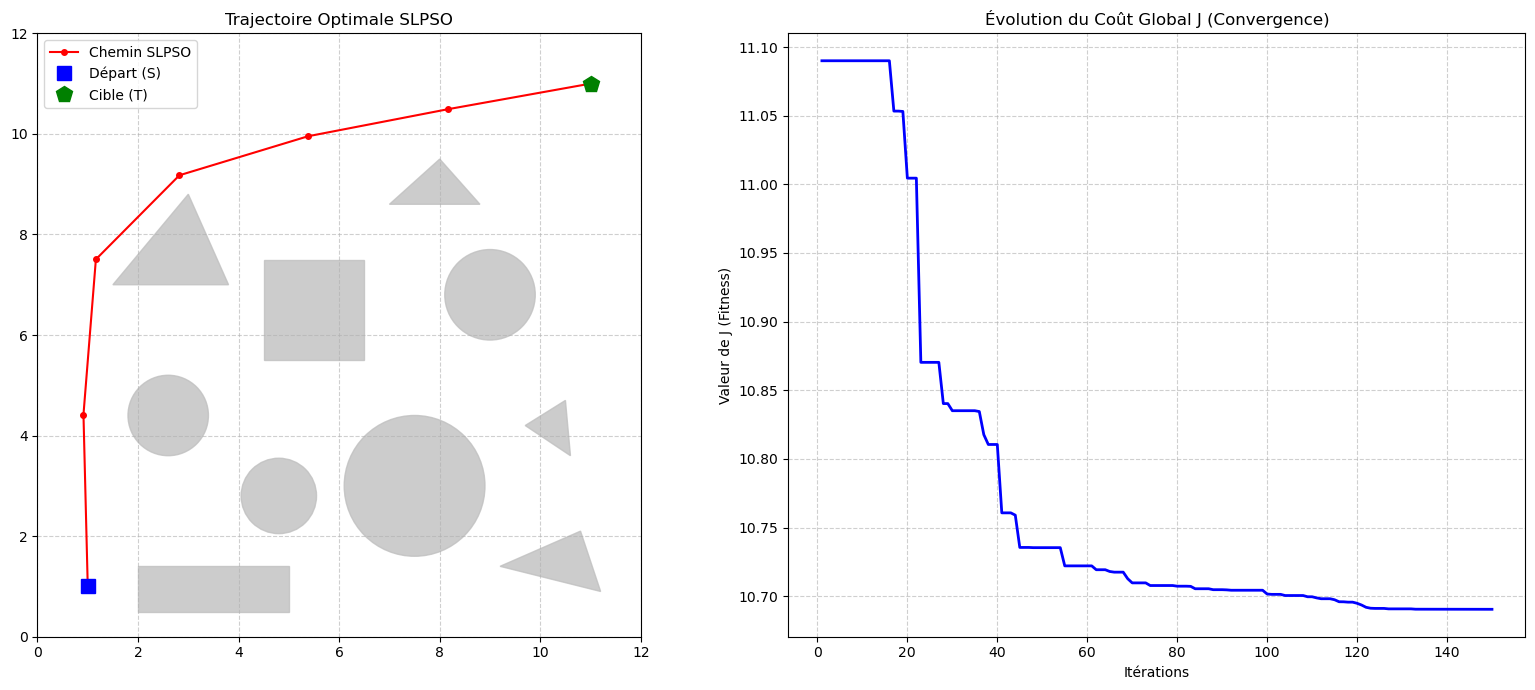


--- Statistiques du meilleur chemin ---
Coût Final J : 10.6905
Longueur totale : 17.26 m
Indice de douceur : 1.42 rad


In [13]:
# --- affichage 
D_WAYPOINTS = 5
N_PARTICULES = 30
MAX_ITER = 150
import random 
SEED = 42
np.random.seed(SEED)
random.seed(SEED) 
modele = TrajectoireModel(POINT_DEPART, POINT_CIBLE, D_WAYPOINTS)
evaluateur = EvaluateurChemin(mon_env)
algo_slpso = SLPSO(mon_env, modele, evaluateur, n_particles=N_PARTICULES)

# --- 2. LANCEMENT DE L'ALGORITHME ---
print("Démarrage de l'optimisation SLPSO...")
algo_slpso.optimiser(max_iter=MAX_ITER)

# --- 3. RÉCUPÉRATION DES RÉSULTATS ---
# Conseil : construire le chemin complet S + (D waypoints) + T
wp = modele.local_to_global(algo_slpso.gbest_pos)  # waypoints internes
chemin_final = np.vstack([POINT_DEPART, wp, POINT_CIBLE])

# --- 4. VISUALISATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# A. Trajectoire
ax1.set_title("Trajectoire Optimale SLPSO")
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 12)
ax1.set_aspect('equal')

for obs in mon_env.obstacles:
    if obs['type'] == 'cercle':
        ax1.add_patch(plt.Circle(obs['centre'], obs['rayon'], color='silver', alpha=0.8))
    elif obs['type'] == 'rectangle':
        ax1.add_patch(plt.Rectangle(obs['ancre'], obs['largeur'], obs['hauteur'], color='silver', alpha=0.8))
    elif obs['type'] == 'triangle':
        ax1.add_patch(plt.Polygon(obs['sommets'], closed=True, color='silver', alpha=0.8))
        
ax1.plot(chemin_final[:, 0], chemin_final[:, 1], 'r-o', markersize=4, label='Chemin SLPSO')
ax1.plot(POINT_DEPART[0], POINT_DEPART[1], 'bs', markersize=10, label='Départ (S)')
ax1.plot(POINT_CIBLE[0], POINT_CIBLE[1], 'gp', markersize=12, label='Cible (T)')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()
# B. Convergence
ax2.set_title("Évolution du Coût Global J (Convergence)")
iters = np.arange(1, len(algo_slpso.history) + 1)   # itérations 1..N
ax2.plot(iters, algo_slpso.history, color='blue', linewidth=2)
ax2.set_xlabel("Itérations")
ax2.set_ylabel("Valeur de J (Fitness)")
ax2.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print(f"\n--- Statistiques du meilleur chemin ---")
print(f"Coût Final J : {algo_slpso.gbest_cost:.4f}")
print(f"Longueur totale : {evaluateur.calculer_longueur(chemin_final):.2f} m")
print(f"Indice de douceur : {evaluateur.calculer_douceur(chemin_final):.2f} rad")

Démarrage de l'optimisation SLPSO...
Itération 1 | Meilleur coût: 1000000000.00
Itération 10 | Meilleur coût: 1000000000.00
Itération 20 | Meilleur coût: 1000000000.00
Itération 30 | Meilleur coût: 11.27
Itération 40 | Meilleur coût: 11.27
Itération 50 | Meilleur coût: 10.99
Itération 60 | Meilleur coût: 10.96
Itération 70 | Meilleur coût: 10.82
Itération 80 | Meilleur coût: 10.81
Itération 90 | Meilleur coût: 10.80
Itération 100 | Meilleur coût: 10.75
Itération 110 | Meilleur coût: 10.71
Itération 120 | Meilleur coût: 10.71
Itération 130 | Meilleur coût: 10.70
Itération 140 | Meilleur coût: 10.70
Itération 150 | Meilleur coût: 10.69

Démarrage de l'optimisation PSO Standard...


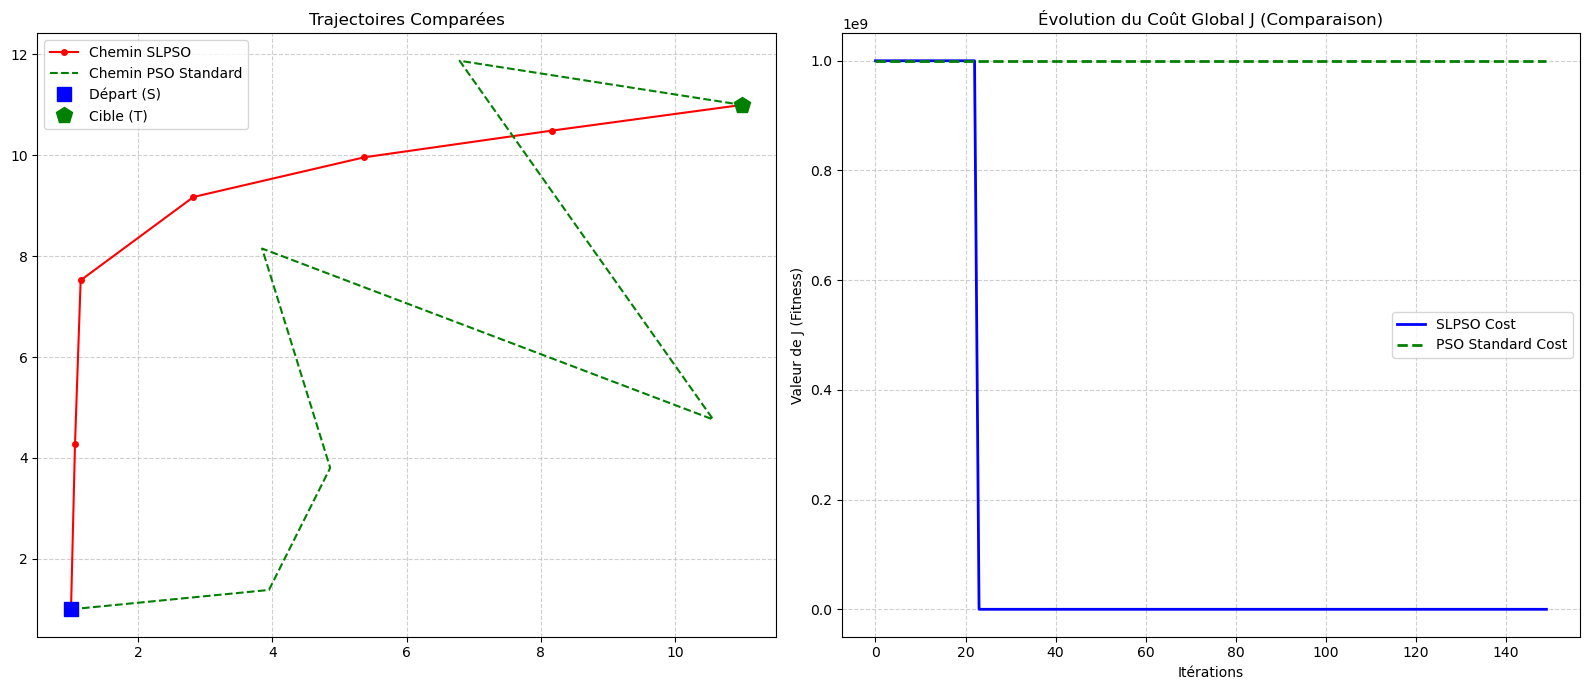


--- Statistiques du meilleur chemin SLPSO ---
Coût Final J : 10.6937

--- Statistiques du meilleur chemin PSO Standard ---
Coût Final J : 1000000000.0000
Longueur totale : 29.91 m
Indice de douceur : 8.73 rad


In [15]:
# --- CLASSE PSO STANDARD (VERSION SIMPLIFIÉE DE SLPSO) ---
class PSOStandard:
    def __init__(self, environnement, modele_trajectoire, evaluateur, n_particles=30):
        self.env = environnement
        self.modele = modele_trajectoire
        self.evaluateur = evaluateur
        self.D = modele_trajectoire.D
        
        self.swarm = [Particle(self.D) for _ in range(n_particles)] # Utilise la même classe Particle
        
        self.gbest_pos = np.zeros(self.D)
        self.gbest_cost = float('inf')
        self.history = []

        # Coefficients PSO standard (pas d'auto-adaptation ici)
        self.c1 = 1.496 # Poids cognitif (Pbest)
        self.c2 = 1.496 # Poids social (Gbest)

    def optimiser(self, max_iter=150):
        # Initialisation silencieuse du Gbest
        for p in self.swarm:
            pts = self.modele.local_to_global(p.position)
            p.pbest_cost = self.evaluateur.evaluer(pts)
            if p.pbest_cost < self.gbest_cost:
                self.gbest_cost = p.pbest_cost
                self.gbest_pos = np.copy(p.position)

        # Boucle principale du PSO Standard
        for k in range(max_iter):
            w = 0.9 - (k / max_iter) * 0.5 # Inertie décroissante (Eq. 11)
            
            for p in self.swarm:
                r1, r2 = np.random.rand(self.D), np.random.rand(self.D)
                
                # Mise à jour de la vitesse (formule PSO standard)
                p.velocity = (w * p.velocity + 
                              self.c1 * r1 * (p.pbest_pos - p.position) +
                              self.c2 * r2 * (self.gbest_pos - p.position))
                
                # Mise à jour de la position
                p.position += p.velocity
                
                # Gestion des limites (réutilisons la méthode de SLPSO)
                self.gerer_limites(p) # Il faut que cette fonction existe dans la classe SLPSO et soit accessible ou copiée

                # Évaluation du coût
                pts = self.modele.local_to_global(p.position)
                cout = self.evaluateur.evaluer(pts)
                
                # Mise à jour Pbest / Gbest
                if cout < p.pbest_cost:
                    p.pbest_cost = cout
                    p.pbest_pos = np.copy(p.position)
                
                if cout < self.gbest_cost:
                    self.gbest_cost = cout
                    self.gbest_pos = np.copy(p.position)

            self.history.append(self.gbest_cost)
            # Affichage pour le PSO Standard (optionnel)
            # if (k + 1) % 10 == 0 or k == 0:
            #     print(f"PSO Std Itération {k + 1} | Meilleur coût: {self.gbest_cost:.2f}")

    # Cette méthode doit être disponible pour le PSO Standard
    def gerer_limites(self, p):
        v_max = 5.0 
        p.velocity = np.clip(p.velocity, -v_max, v_max)
        u, l = 5.0, -5.0 # Bornes Y' locales
        for d in range(self.D):
            if p.position[d] > u: p.position[d] = 2 * u - p.position[d]
            elif p.position[d] < l: p.position[d] = 2 * l - p.position[d]
        p.position = np.clip(p.position, l, u)

# --- MISE À JOUR DU SCRIPT DE VISUALISATION ---

# --- 1. INITIALISATION DES COMPOSANTS ---
# ... (votre code existant pour D_WAYPOINTS, N_PARTICULES, MAX_ITER) ...

# Création des objets pour SLPSO
modele = TrajectoireModel(POINT_DEPART, POINT_CIBLE, D_WAYPOINTS)
evaluateur = EvaluateurChemin(mon_env)
algo_slpso = SLPSO(mon_env, modele, evaluateur, n_particles=N_PARTICULES)

# --- NOUVEAU : Création des objets pour PSO Standard ---
algo_pso_std = PSOStandard(mon_env, modele, evaluateur, n_particles=N_PARTICULES)


# --- 2. LANCEMENT DES ALGORITHMES ---
print("Démarrage de l'optimisation SLPSO...")
algo_slpso.optimiser(max_iter=MAX_ITER)

print("\nDémarrage de l'optimisation PSO Standard...")
algo_pso_std.optimiser(max_iter=MAX_ITER)


# --- 3. RÉCUPÉRATION DES RÉSULTATS ---
chemin_final_slpso = modele.local_to_global(algo_slpso.gbest_pos)
chemin_final_pso_std = modele.local_to_global(algo_pso_std.gbest_pos) # Nouveau chemin PSO Std


# --- 4. VISUALISATION MISE À JOUR ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# A. Affichage de la Trajectoire
ax1.set_title("Trajectoires Comparées")
# ... (votre code existant pour les obstacles, les limites) ...

# Tracé du chemin SLPSO
ax1.plot(chemin_final_slpso[:, 0], chemin_final_slpso[:, 1], 'r-o', markersize=4, label='Chemin SLPSO')
# NOUVEAU : Tracé du chemin PSO Standard (en vert par exemple)
ax1.plot(chemin_final_pso_std[:, 0], chemin_final_pso_std[:, 1], 'g--', markersize=2, label='Chemin PSO Standard')

ax1.plot(POINT_DEPART[0], POINT_DEPART[1], 'bs', markersize=10, label='Départ (S)')
ax1.plot(POINT_CIBLE[0], POINT_CIBLE[1], 'gp', markersize=12, label='Cible (T)')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()


# B. Affichage de la Convergence (Figure 6 de l'article)
ax2.set_title("Évolution du Coût Global J (Comparaison)")
ax2.plot(algo_slpso.history, color='blue', linewidth=2, label='SLPSO Cost')
# NOUVEAU : Ajout de la courbe PSO Standard
ax2.plot(algo_pso_std.history, color='green', linestyle='--', linewidth=2, label='PSO Standard Cost')

ax2.set_xlabel("Itérations")
ax2.set_ylabel("Valeur de J (Fitness)")
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

plt.tight_layout()
plt.show()

# --- 5. STATISTIQUES FINALES ---
print(f"\n--- Statistiques du meilleur chemin SLPSO ---")
print(f"Coût Final J : {algo_slpso.gbest_cost:.4f}")
# ... (autres stats pour SLPSO) ...

print(f"\n--- Statistiques du meilleur chemin PSO Standard ---")
print(f"Coût Final J : {algo_pso_std.gbest_cost:.4f}")
print(f"Longueur totale : {evaluateur.calculer_longueur(chemin_final_pso_std):.2f} m")
print(f"Indice de douceur : {evaluateur.calculer_douceur(chemin_final_pso_std):.2f} rad")